## Analyzing "stranger","danger" query

Melissa was interested to hear how the phrase “stranger danger” has been used over time, and where it came from.
Therefore we run a query against the BL books using the words “stranger” and “danger” (**maching criteria**) within the same sentence, which generates an ouput file (stranger_danger.yml).


This output file has an entry for each book where sentences matching the criteria has found, which follows this schema:
- Tittle
    - Publisher
    - Year
    - ID_Book
      - SENTENCE MATCHING THE CRITERIA
        - Page
      - SENTENCE MATCHING THE CRITERIA
        - Page       
        
For example:
- Poems ... viz. The Hermaphrodite. The Remedie of Love. Elegies. Sonnets, with other poems 
    - Richard Hodgkinson, for W. W. and Laurence Blaikelocke 
    - 1640 
    - '000241254' 
        - [stranger, '', loves, delight, and, sweetest, blisse, is, got, with, greatest, danger]
            - '000070'
            
Therefore the "sentences" are naturally grouped by the book where they have found. However, a book can be replicated in our initial dataset. So, we have to be carreful when we analyse the data. For that reason, we are going to read first the input file in a dataframe (called bdf), and later we are going to create a new one (called bdf_t) where we have grouped the books by code, and aggregate all the sentences into the same column.



### Importing the python libraries

In [21]:
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import numpy as np
import collections
import nltk
from nltk.corpus import stopwords
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import sentiwordnet as swn
from textblob import TextBlob
import re
from wordcloud import WordCloud

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/rosafilgueira/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rosafilgueira/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rosafilgueira/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Reading the input file and importing into a temporal dataframe (bdf)

In [2]:
filename= "stranger_danger.yml"
with open(filename, 'r') as f:
        results = yaml.load(f)
bdf = pd.DataFrame(results['(stranger, danger)'])
bdf.rename(columns={0: 'title', 1: 'publisher', 2:'year', 3: 'code', 4: 'content'} , inplace=True)

#### Exploring the bdf dataframe

Each row represente a book entry, which sentences maching the criteria have been found.

In [3]:
print "First row of the dataframe:"
bdf.head(1)

First row of the dataframe:


,title,publisher,year,code,content
0,Poems ... viz. The Hermaphrodite. The Remedie ...,"Richard Hodgkinson, for W. W. and Laurence Bla...",1640,000241254,"[[[stranger, , loves, delight, and, sweetest, ..."


In [4]:
print "Number of books (including repetitions) - Number of columns: ", bdf.shape

Number of books (including repetitions) - Number of columns:  (872, 5)


In [5]:
print "The total number of books (grouped by their codes) is ", bdf.groupby(['code'])["title"].size().value_counts().sum()

print "Same result:," , bdf['code'].nunique()

The total number of books (grouped by their codes) is  817
Same result:, 817


### Creating a new dataframe (bdf_t) 

We have merged in bdf_t all the rows of the same books into one, by aggregating all the sentences into "content" column. Furthermore,  we have added a new column (called repetition), to store the number of times that a book, where sentences maching the cretieria have been found, appears in our dataset.

In [8]:
bdf_t = pd.DataFrame()
list_codes=bdf['code'].unique()
for c in list_codes:
    df = bdf[bdf['code'] == c]
    repetition=len(df)
    if repetition!=1:
        publisher=df.iloc[0]["publisher"]
        title= df.iloc[0]["title"]
        year= df.iloc[0]["year"]
        df=df.groupby(["code"], as_index=False)['content'].sum()
        df['publisher']=publisher
        df['year']=year
        df['title']=title
    df=df.assign(repetition = repetition)
    bdf_t = bdf_t.append(df, ignore_index=True)   
bdf_t.set_index('code',inplace = True)


#### Exploring the bdf_t dataframe --> From now on, we are going to work with bdf_t dataframe

In [9]:
print "Number of books (without repetitions) - Number of columns: ", bdf_t.shape

Number of books (without repetitions) - Number of columns:  (817, 5)


### Exploring the frequency of  books repetition in our dataset --> using bdf_t dataframe

Text(0,0.5,u'No. of Books')

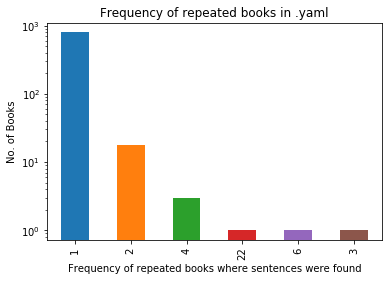

In [10]:
bdf_t['repetition'].value_counts().plot(kind='bar', title='Frequency of repeated books in .yaml')
plt.yscale('log', nonposy='clip')
plt.xlabel('Frequency of repeated books where sentences were found', fontsize=10)
plt.ylabel('No. of Books', fontsize=10)

### Getting the most replicated book's title

In [11]:
print "The book:", bdf_t[bdf_t['repetition']== bdf_t['repetition'].max()]["title"], " --> has", bdf_t['repetition'].max() , " replications"

The book: code
000044627    Aldine “O'er Land and Sea.” Library
Name: title, dtype: object  --> has 22  replications


### Exploring the books' repetitions that appear more than once in our dataset

Text(0,0.5,u'No. of Repetitions- logarithmically scale')

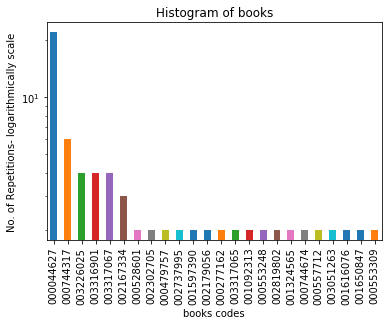

In [12]:
freq_code=bdf_t[bdf_t['repetition'] >1]['repetition']
freq_code.sort_values(ascending=False).plot(kind='bar', title='Histogram of books')
plt.yscale('log', nonposy='clip')
plt.xlabel('books codes', fontsize=10)
plt.ylabel('No. of Repetitions- logarithmically scale', fontsize=10)

### year-frequency histogram

We have  817  books, which their year frequency/distribution is the following


Text(0,0.5,u'No. of Books- logarithmically scale')

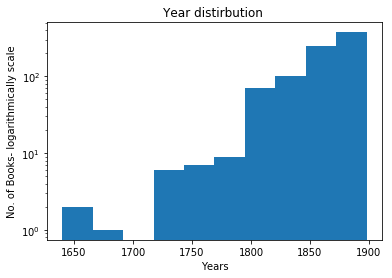

In [13]:
list_year = bdf_t["year"].values
print "We have ", len(list_year)," books, which their year frequency/distribution is the following" 
plt.hist(list_year)
plt.yscale('log', nonposy='clip')
plt.title("Year distirbution ")
plt.xlabel('Years', fontsize=10)
plt.ylabel('No. of Books- logarithmically scale', fontsize=10)

### Normalisation

In [14]:
normal_filename = 'normaliser.yml'
with open('./' + normal_filename, 'r') as f:
    publication = yaml.load(f)

Text(0,0.5,u'No. of Books')

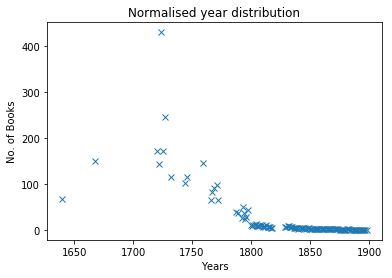

In [15]:
normed_results = {}
d_year=collections.Counter(list_year)
for year in d_year:
    if year>0:
        normed_results[year] = year/float(publication[year][0])
plt.plot(normed_results.keys(), normed_results.values(), 'x')
plt.title("Normalised year distribution")
plt.xlabel('Years', fontsize=10)
plt.ylabel('No. of Books', fontsize=10)

These stages carry out normalisation: dividing the per year word occurence with the per year book occurence to get a words per book per year measure.
- year: [count, count_pages, count_words]}
- 1788: [102, 22588, 4055011]

### Getting the  sentences (and books, which those belong) with words *stranger* and *danger* next to each other

In [16]:
phrase=["stranger","danger"]
total_sentences =0
total_books =0
for index, row in bdf_t.iterrows():
    sentences= row['content']
    title = row['title']
    year = row['year']
    flag=0
    for s in sentences:
        for w in range(0,len(s[0])-1):
            first_word= s[0][w]
            second_word=s[0][w+1]           
            if [first_word, second_word]==phrase:
                print "Book: ",title, ",Year: ", year, ",Sentence: ",s[0], "Page: ", s[1]
                total_sentences+= 1
                flag=1
    if flag==1:
        total_books+=1
        flag=0
print "---> Total sentences with 'stranger' & 'danger' next to each other:", total_sentences
print "---> Total books with 'stranger' & 'danger' together:", total_books


Book:  Caught by a Cook ,Year:  1895 ,Sentence:  ['who', 'knew', 'most', 'of', 'the', 'villagers', 'by', 'sight', 'perceived', 'a', 'stranger', 'danger'] Page:  000105
---> Total sentences with 'stranger' & 'danger' next to each other: 1
---> Total books with 'stranger' & 'danger' together: 1


### Getting the total number of sentences found, and the book title which has the max. number of sentences  maching our criteria (sentences that have *stranger* and *danger*) 

In [17]:
num_books = len(bdf_t)
max_sentences =0
total_sentences =0
for index, row in bdf_t.iterrows():
    num_sentences= len(row['content'])
    total_sentences= total_sentences + num_sentences
    if num_sentences > max_sentences:
        max_sentences= num_sentences
        max_code = index

In [18]:
print "Total sentences found is ", total_sentences, " \n"
max_title=bdf_t.loc[max_code]["title"]
max_year=bdf_t.loc[max_code]["year"]
print"The book --", max_title, "--publish at ", max_year," ,(code  ",max_code, ") has the max num sentences: ", max_sentences

Total sentences found is  1038  

The book -- Aldine “O'er Land and Sea.” Library --publish at  1890  ,(code   000044627 ) has the max num sentences:  29


### Frequency of the number of sentences per book where sentences maching our criteria (sentences that have *stranger* and *danger* ) have been found

Text(0,0.5,u'no of books, logarithmically scale ')

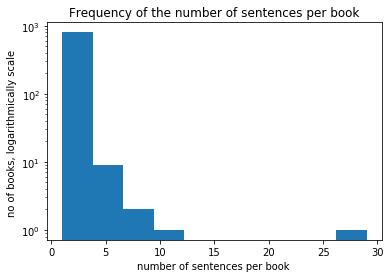

In [19]:
num_books = len(bdf_t)
max_sentences =0
total_sentences =0
num_senteces_freq=[]
for index, row in bdf_t.iterrows():
    num_sentences= len(row['content'])
    num_senteces_freq.append(num_sentences)
     
plt.hist(num_senteces_freq)
plt.yscale('log', nonposy='clip')
plt.title("Frequency of the number of sentences per book")
plt.xlabel('number of sentences per book ', fontsize=10)
plt.ylabel('no of books, logarithmically scale ', fontsize=10)

### Exploring which words from the book "Aldine “O'er Land and Sea" appear more 

- Note1: This book has the max. number of sentences maching our criteria.

- Note2: We have to remove "stranger" and "danger" words

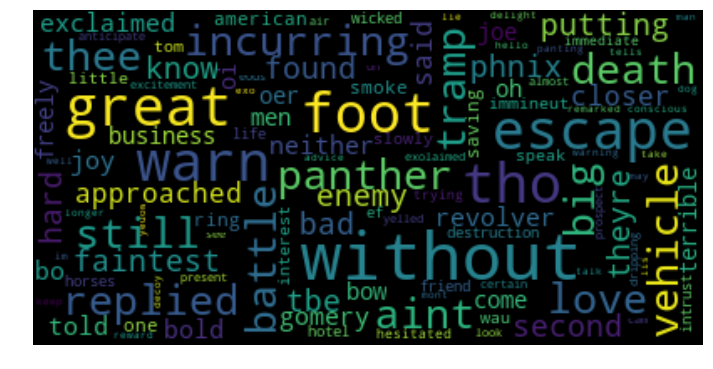

In [22]:
text_q1=''
filter_book= bdf_t.loc[bdf_t["title"] == max_title]["content"]
for i in filter_book.sum():
    for w in i[0]:
       if w!="stranger" and w!="danger":
           if w not in stopwords.words('english'):
                text_q1= text_q1 +" " + w
    
wordcloud = WordCloud(max_font_size=40).generate(text_q1)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Exploring which words from the book "Caught by a Cook" appear more 

- Note1: This is the only book with sentences *stranger* and *danger* words next to each other

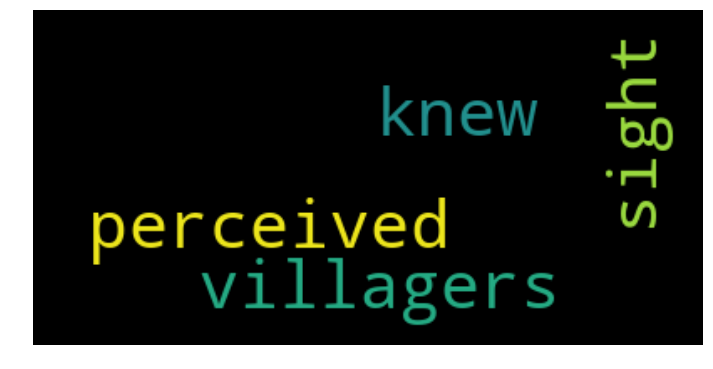

In [23]:
text_q1=''
title='Caught by a Cook'
filter_book= bdf_t.loc[bdf_t["title"] == title]["content"]
for i in filter_book.sum():
    for w in i[0]:
       if w!="stranger" and w!="danger":
           if w not in stopwords.words('english'):
               text_q1= text_q1 +" " + w
    
wordcloud = WordCloud(max_font_size=40).generate(text_q1)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Exploring the *sentiment* of the words of "Caught by a Cook" book 

In [24]:

def last_chars(x):
    '''
    Utility function to get the last 25 characters.
    '''
    return(x[-25:])

def clean_text(text):
    '''
    Utility function to clean the text in a text by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())

def analize_sentiment(text):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''

    analysis = TextBlob(clean_text(text))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [25]:
title="Caught by a Cook"
filter_book= bdf_t.loc[bdf_t["title"] == title]["content"]
text_q1=[]
for i in filter_book.sum():
    text=''
    for w in i[0]:
        text= text +" " + w
    text_q1.append(text)
        
#print the sentiment analysis 
for i in range(len(text_q1)):
    print "The sementiment of: ", text_q1[i]," --> is : " ,analize_sentiment(text_q1[i])


The sementiment of:   who knew most of the villagers by sight perceived a stranger danger  --> is :  1


## Exploring which words appears more in our senteces

Note--> we have to remove "stranger" and "danger" words

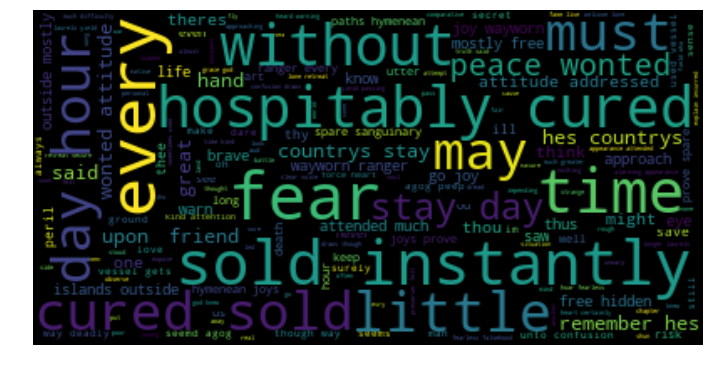

In [26]:
text_q1=''
for book in range(0,num_books):
        for w in bdf_t["content"][book][0][0]:
            if w!="stranger" and w!="danger":
                if w not in stopwords.words('english'):
                    text_q1= text_q1 +" " + w
    
wordcloud = WordCloud(max_font_size=40).generate(text_q1)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()